# <span style="color:green"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:red"><center>Carga de imágenes</center></span>

<center>Técnicas Tensorflow 2.x</center>

##   <span style="color:blue">Profesores</span>

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

## <span style="color:blue">Referencias</span> 

1. Adaptado de [Load images](https://www.tensorflow.org/tutorials/load_data/images)

## <span style="color:blue">Contenido</span>  

* [Introducción](#Introducción)
* [Configuración](#Configuración)
* [Descargar conjunto de datos de flores](#Descargar-conjunto-de-datos-de-flores)
* [Cargar usando keras.preprocessing](#Cargar-usando-keras.preprocessing)
* [Configurar el conjunto de datos para buen rendimiento](#Configurar-el-conjunto-de-datos-para-buen-rendimiento)
* [Crea, compila y entrena el modelo](#Crea,-compila-y-entrena-el-modelo)
* [Uso de tf.data para un control más preciso](#Uso-de-tf.data-para-un-control-más-preciso)
* [Usar conjuntos de datos de TensorFlow](#Usar-conjuntos-de-datos-de-TensorFlow)


## <span style="color:blue">Introducción</span>

Este tutorial muestra cómo cargar y preprocesar un conjunto de datos de imágenes de tres formas. 

1. En primer lugar, utilizará capas y utilidades de preprocesamiento de Keras de alto nivel para leer un directorio de imágenes en el disco. 
1. A continuación, escribirá su propia canalización de entrada desde cero utilizando tf.data. 
1. Finalmente, descargará un conjunto de datos del gran catálogo disponible en TensorFlow Datasets .



## <span style="color:blue">Configuración</span>

In [ ]:
# !conda install -c anaconda pillow=8.0
# !conda install -c anaconda tensorflow-datasets

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.4.1


## <span style="color:blue">Descargar conjunto de datos de flores</span>

Este tutorial utiliza un conjunto de datos de varios miles de fotos de flores. El conjunto de datos de flores contiene 5 subdirectorios, uno por clase.

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)

In [5]:
data_dir

'/home/alvaro/.keras/datasets/flower_photos'

In [6]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/home/alvaro/.keras/datasets/flower_photos')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Cada directorio contiene imágenes de ese tipo de flor. Aquí hay algunas rosas:

In [14]:
roses = list(data_dir.glob('roses/*'))
roses[0:5]

[PosixPath('/home/alvaro/.keras/datasets/flower_photos/roses/8035908422_87220425d2_n.jpg'),
 PosixPath('/home/alvaro/.keras/datasets/flower_photos/roses/475947979_554062a608_m.jpg'),
 PosixPath('/home/alvaro/.keras/datasets/flower_photos/roses/4723876257_d87b781986.jpg'),
 PosixPath('/home/alvaro/.keras/datasets/flower_photos/roses/22506717337_0fd63e53e9.jpg'),
 PosixPath('/home/alvaro/.keras/datasets/flower_photos/roses/16670921315_0fc48d7ab2_n.jpg')]

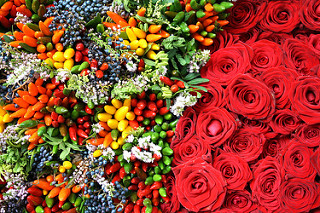

In [15]:
PIL.Image.open(str(roses[0]))

In [16]:
str(roses[0])

'/home/alvaro/.keras/datasets/flower_photos/roses/8035908422_87220425d2_n.jpg'

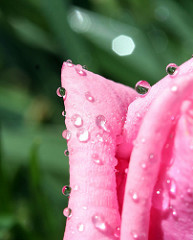

In [17]:
PIL.Image.open(str(roses[1]))

## <span style="color:blue">Cargar usando keras.preprocessing</span>

### Crea un conjunto de datos

 Define algunos parámteros

In [19]:
batch_size = 32
img_height = 180
img_width = 180

Separa datos de entrenamiento(80%) y validación(20%) 

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Puede encontrar los nombres de las clases en el atributo class_names en estos conjuntos de datos.

In [23]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualiza los datos

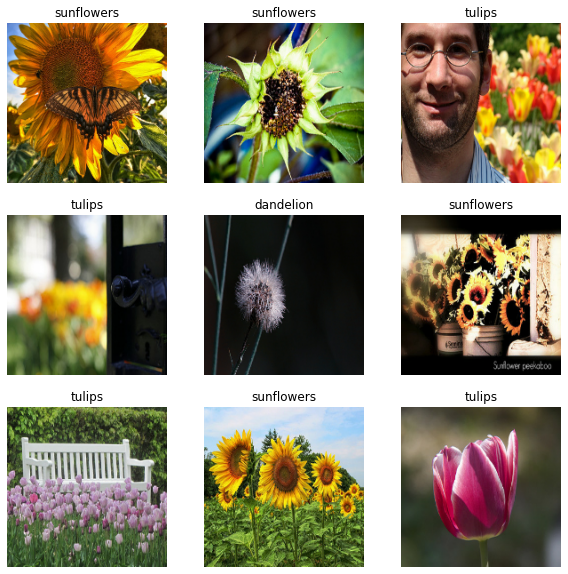

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

Puede entrenar un modelo con estos conjuntos de datos pasándolos a *model.fit* (que se muestra más adelante en este tutorial). Si lo desea, también puede iterar manualmente sobre el conjunto de datos y recuperar lotes de imágenes:

In [30]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Estandariza los datos

In [34]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255) 

Hay dos formas de utilizar esta capa. Puede aplicarlo al conjunto de datos llamando a map:

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.009804222 1.0


O puede incluir la capa dentro de la definición de su modelo para simplificar la implementación.  Haremos el seguno enfoque 

## <span style="color:blue">Configurar el conjunto de datos para buen rendimiento</span>

Asegurémonos de utilizar la captación previa en búfer para que podamos generar datos desde el disco sin que la E / S se bloquee. Estos son dos métodos importantes que debe utilizar al cargar datos.

+ `.cache()` mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear una caché en disco de alto rendimiento.

+ `.prefetch()` superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento. Es decir carga el siguiente lotes de datos que se procesará, mientras el modelo utliza el lote actual de datos.

Pueden obtener más información sobre ambos métodos, así como sobre cómo almacenar en caché los datos en el disco en la [guía de rendimiento de datos](https://www.tensorflow.org/guide/data_performance#prefetching).

In [36]:
AUTOTUNE = tf.data. AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## <span style="color:blue">Crea, compila y entrena el modelo</span>

In [38]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [41]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 3
)

Epoch 1/3
92/92 [==============================] - 87s 885ms/step - loss: 1.4430 - accuracy: 0.3622 - val_loss: 1.0974 - val_accuracy: 0.5722
Epoch 2/3
92/92 [==============================] - 76s 822ms/step - loss: 1.0060 - accuracy: 0.6091 - val_loss: 0.9869 - val_accuracy: 0.6322
Epoch 3/3
92/92 [==============================] - 81s 882ms/step - loss: 0.8524 - accuracy: 0.6778 - val_loss: 0.9660 - val_accuracy: 0.6199


## <span style="color:blue">Uso de tf.data para un control más preciso</span>

Las utilidades keras.preprocessing anteriores son una forma conveniente de crear un `tf.data.Dataset` a partir de un directorio de imágenes. Para un control más fino, puede escribir su propia canalización de entrada usando `tf.data`. Esta sección muestra cómo hacer precisamente eso, comenzando con las rutas de archivo del zip que descargamos anteriormente.

In [43]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'),shuffle=False) # est es un error. Debe ser shuffle=True

In [42]:
str(data_dir/'*/*')

'/home/alvaro/.keras/datasets/flower_photos/*/*'

In [47]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/alvaro/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'
b'/home/alvaro/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'
b'/home/alvaro/.keras/datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'
b'/home/alvaro/.keras/datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'
b'/home/alvaro/.keras/datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg'


La estructura de árbol de los archivos se puede utilizar para compilar una lista de class_names.

In [60]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Divide datos en entrenamiento y validación

In [72]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Puede ver la longitud de cada conjunto de datos de la siguiente manera:

In [73]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


### Escriba una función corta que convierta una ruta de archivo en un par (img, label) :

In [75]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [79]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [80]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use `Dataset.map` para crear un conjunto de datos de image, pares de (image, label):

In [81]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [82]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    

Image shape:  (180, 180, 3)
Label:  1


### Configurar el conjunto de datos para el mejor rendimiento

Para entrenar un modelo con este conjunto de datos, necesitará que los datos:

* Estén bien barajado.
* listos para ser procesadoa.
* Los lotes estarán disponibles lo antes posible.

Estas funciones se pueden agregar usando la API tf.data . Para obtener más detalles, consulte la guía Input Pipeline Performance .

In [83]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualiza los datos

Puede visualizar este conjunto de datos de manera similar al que creó anteriormente.

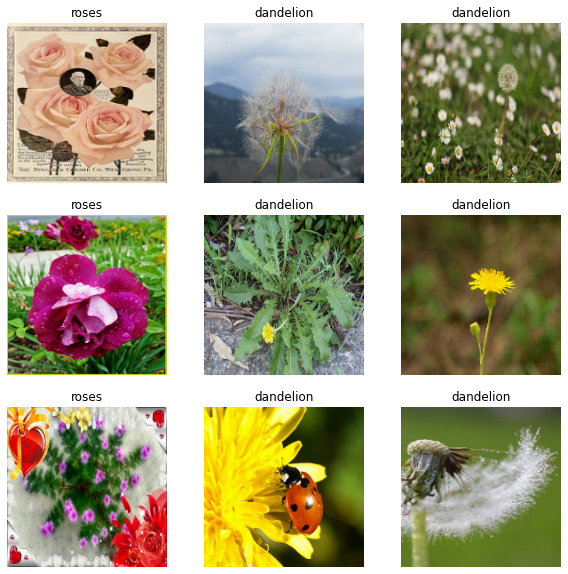

In [84]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

### Continua el entrenamiento

Ahora ha creado manualmente un `tf.data.Dataset` similar al creado por keras.preprocessing anterior. Puede continuar entrenando el modelo con él. Como antes, entrenaremos solo unas pocas épocas para reducir el tiempo de ejecución.

In [86]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 88s 960ms/step - loss: 0.5219 - accuracy: 0.7946 - val_loss: 5.7856 - val_accuracy: 0.1035
Epoch 2/3
92/92 [==============================] - 93s 1s/step - loss: 0.4365 - accuracy: 0.8341 - val_loss: 6.7920 - val_accuracy: 0.0926
Epoch 3/3
92/92 [==============================] - 93s 1s/step - loss: 0.3904 - accuracy: 0.8518 - val_loss: 6.3057 - val_accuracy: 0.0967


## <span style="color:blue">Usar conjuntos de datos de TensorFlow</span>

Hasta ahora, este tutorial se ha centrado en cargar datos fuera del disco. También puede encontrar un conjunto de datos para usar explorando el gran catálogo de conjuntos de datos fáciles de descargar en TensorFlow Datasets . Como anteriormente cargó el conjunto de datos de Flowers fuera del disco, veamos cómo importarlo con los conjuntos de datos de TensorFlow.

Descarga el conjunto de datos de flores con los conjuntos de datos de TensorFlow.

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)